# Load all params learned from Fender dataset: 
In this notebook all model paremeters, i.e:  noise variance, lengthscale and variance of activation, all frequencies, variances and lenghscale of component, and variational distributions are learned simultaneously by maximazing the marginal likelihood.

In [1]:
%matplotlib inline
import sys 
sys.path.append('../../../../')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpflow, gpitch
reload(gpitch)
from gpitch.amtgp import logistic
from scipy.fftpack import fft, ifft, ifftshift
from scipy import signal
import time
from gpitch import myplots
import soundfile
import pickle

plt.rcParams['figure.figsize'] = (16, 3)  # set plot size

In [2]:
m_60 = pickle.load(open("save_model_pitch_60.p", "rb"))
m_64 = pickle.load(open("save_model_pitch_64.p", "rb"))
m_67 = pickle.load(open("save_model_pitch_67.p", "rb"))
models = [m_60, m_64, m_67]

## Import data

Load and plot data.

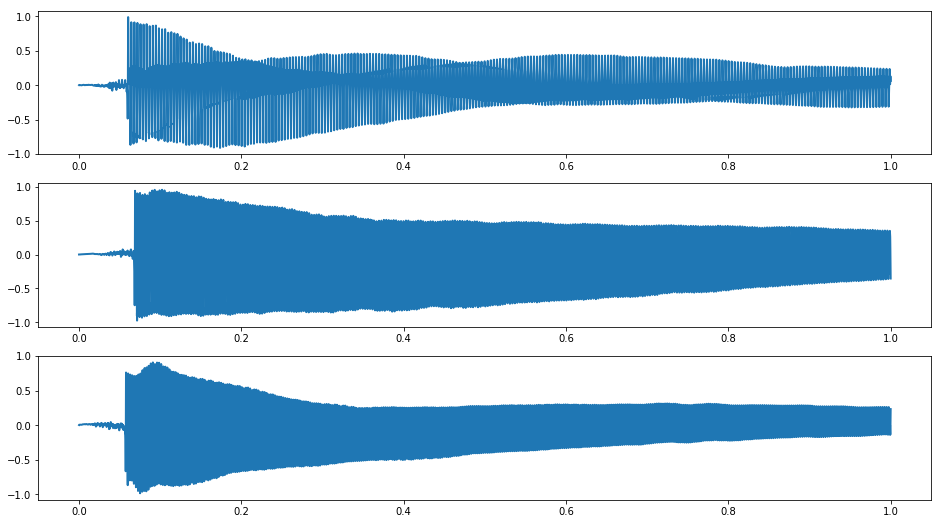

In [3]:
plt.figure(figsize=(16, 9))
plt.title('data')
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(models[i].x.value, models[i].y.value, lw=2)

## Define model
We take advantage of the information available in the Fourier transform of the data to initialize the component hyper-parameters, i.e. the frequency of each harmonic and its variance.

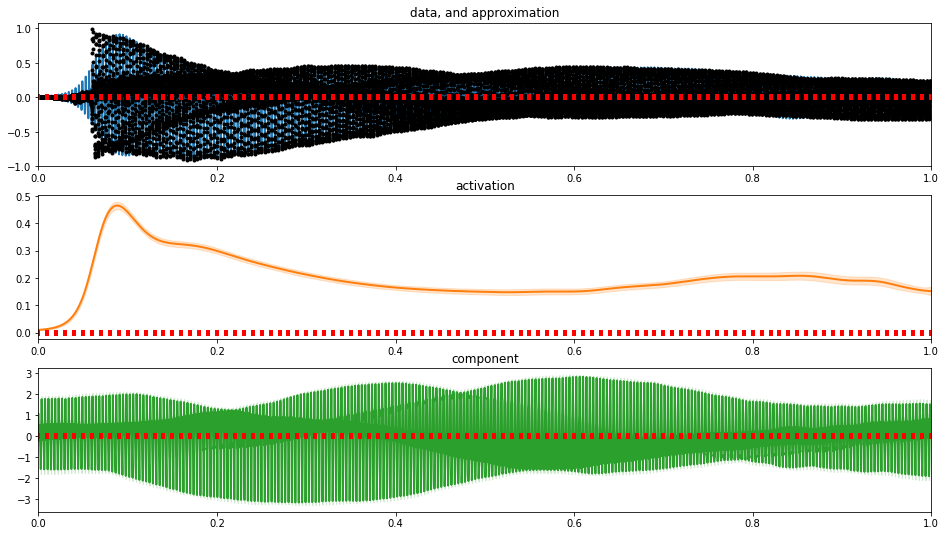

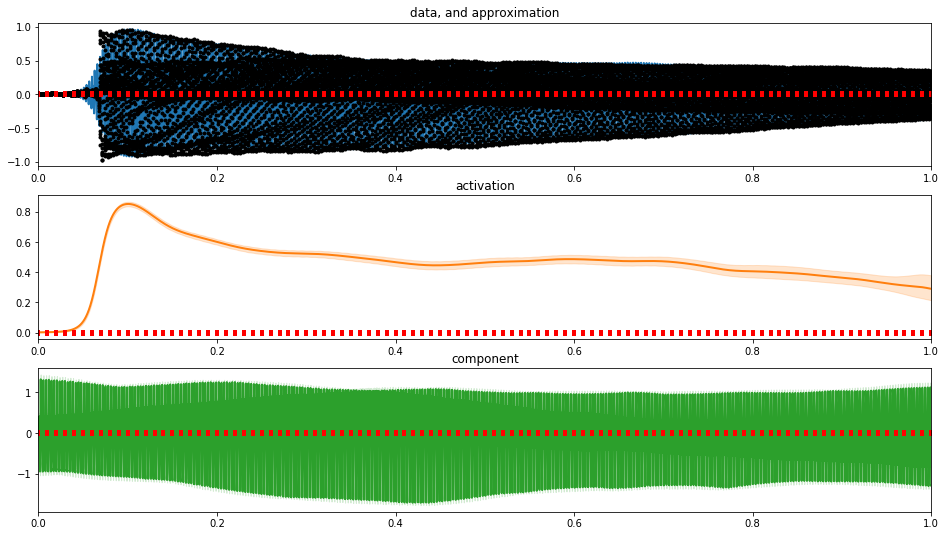

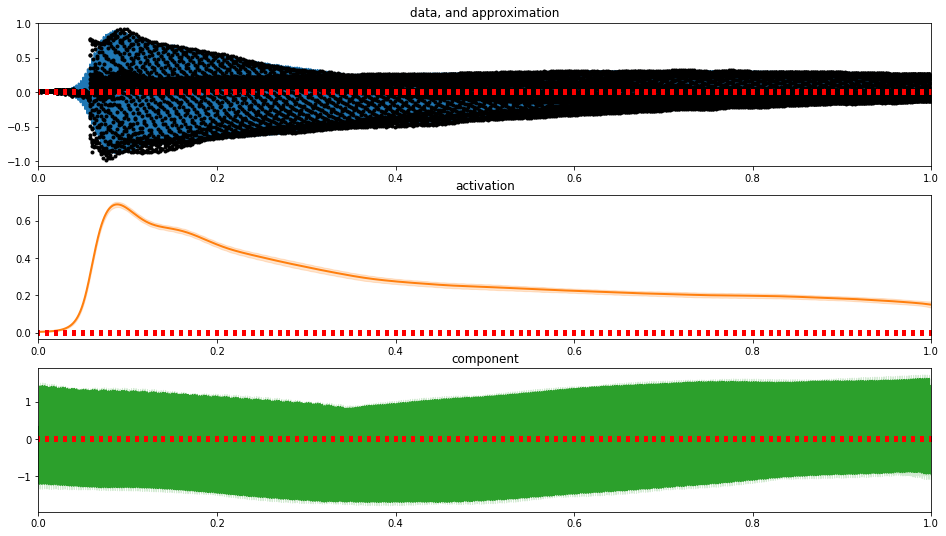

In [4]:
fs = 16000.
for i in range(3):
    x = models[i].x.value.copy()
    y = models[i].y.value.copy()
    z = models[i].z.value.copy()
    N = y.size
    mean_f, var_f, mean_g, var_g, x_plot  = models[i].predict_all(x)
    myplots.plot_results(mean_f, var_f, mean_g, var_g, x_plot, y, z, xlim=[0.0, 1.0])

/home/paad/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


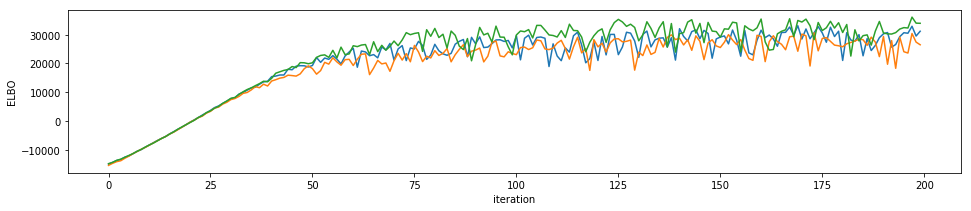

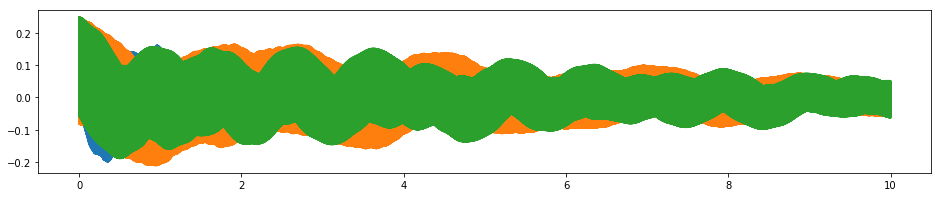

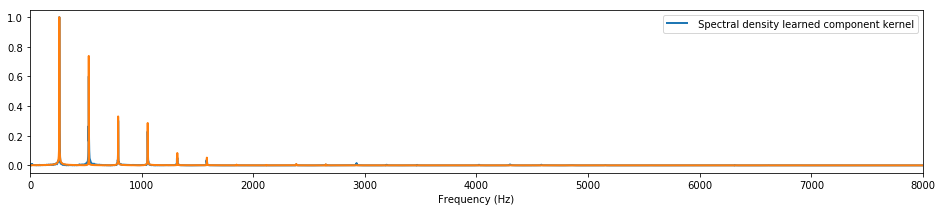

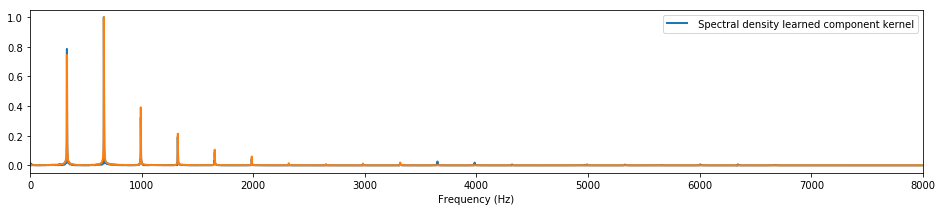

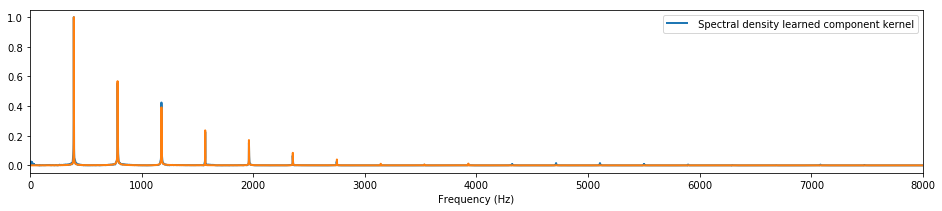

In [5]:
xkernel = np.linspace(0, 10, 10.*fs).reshape(-1, 1)
F = np.linspace(0, fs//2, N//2).reshape(-1, 1)
plt.figure(1)    
plt.figure(2)
plt.figure(3, figsize=(16, 6))

for i in range(3):
    plt.figure(1) 
    plt.plot(-np.array(models[i].logf))
    plt.xlabel('iteration')
    plt.ylabel('ELBO')
    
    plt.figure(2)
    k_plot_model = models[i].kern_com.compute_K(xkernel, np.asarray(0.).reshape(-1,1))
    plt.plot(xkernel, k_plot_model, lw=2)
    
    k_plot_model = models[i].kern_com.compute_K(x, np.asarray(0.).reshape(-1,1))
    Yk1 = fft(k_plot_model.reshape(-1,)) #  FFT data
    Sk1 =  2./N * np.abs(Yk1[0:N//2]) #  spectral density data
    S = np.abs(fft(models[i].y.value.reshape(-1,))[:N//2])
    
    plt.figure()
    plt.plot(F, S / np.max(np.abs(S)), lw=2)
    plt.plot(F, Sk1 / np.max(np.abs(Sk1)), lw=2)
    plt.legend([' Spectral density learned component kernel'])
    plt.xlabel('Frequency (Hz)')
    plt.xlim([0, 8000])

In [6]:
import tensorflow as tf
kern_com_60 = models[0].kern_com
kern_com_64 = models[1].kern_com
kern_com_67 = models[2].kern_com
kern_act_60 = models[0].kern_act
kern_act_64 = models[1].kern_act
kern_act_67 = models[2].kern_act
kern_com_60.fixed = True
kern_com_64.fixed = True
kern_com_67.fixed = True

In [7]:
print ('The ideal natural frequency is ' + str(gpitch.amtgp.midi2frec(60)))

The ideal natural frequency is 261.625565301


In [8]:
kern_com_60

Name,values,prior,constraint
kern_com.frequency_1,[ 262.32623986],None,[FIXED]
kern_com.frequency_10,[ 2649.98284859],None,[FIXED]
kern_com.frequency_2,[ 525.93460211],None,[FIXED]
kern_com.frequency_3,[ 789.30511808],None,[FIXED]
kern_com.frequency_4,[ 1053.6529378],None,[FIXED]
kern_com.frequency_5,[ 1319.21372104],None,[FIXED]
kern_com.frequency_6,[ 1583.63285749],None,[FIXED]
kern_com.frequency_7,[ 1849.96032331],None,[FIXED]
kern_com.frequency_8,[ 2117.99704787],None,[FIXED]
kern_com.frequency_9,[ 2385.33823263],None,[FIXED]


In [9]:
print ('The ideal natural frequency is ' + str(gpitch.amtgp.midi2frec(64)))

The ideal natural frequency is 329.627556913


In [10]:
kern_com_64

Name,values,prior,constraint
kern_com.frequency_1,[ 330.48463144],None,[FIXED]
kern_com.frequency_10,[ 3315.54044715],None,[FIXED]
kern_com.frequency_2,[ 661.4246422],None,[FIXED]
kern_com.frequency_3,[ 992.32742241],None,[FIXED]
kern_com.frequency_4,[ 1323.52792889],None,[FIXED]
kern_com.frequency_5,[ 1654.41928739],None,[FIXED]
kern_com.frequency_6,[ 1986.40350019],None,[FIXED]
kern_com.frequency_7,[ 2318.32563166],None,[FIXED]
kern_com.frequency_8,[ 2650.93424246],None,[FIXED]
kern_com.frequency_9,[ 2982.95555805],None,[FIXED]


In [11]:
print ('The ideal natural frequency is ' + str(gpitch.amtgp.midi2frec(67)))

The ideal natural frequency is 391.995435982


In [12]:
kern_com_67

Name,values,prior,constraint
kern_com.frequency_1,[ 391.83829044],None,[FIXED]
kern_com.frequency_10,[ 3926.81535895],None,[FIXED]
kern_com.frequency_2,[ 784.43829031],None,[FIXED]
kern_com.frequency_3,[ 1177.40102019],None,[FIXED]
kern_com.frequency_4,[ 1568.92872559],None,[FIXED]
kern_com.frequency_5,[ 1961.32105549],None,[FIXED]
kern_com.frequency_6,[ 2353.66995572],None,[FIXED]
kern_com.frequency_7,[ 2748.78598157],None,[FIXED]
kern_com.frequency_8,[ 3141.87124389],None,[FIXED]
kern_com.frequency_9,[ 3534.4009347],None,[FIXED]


41666


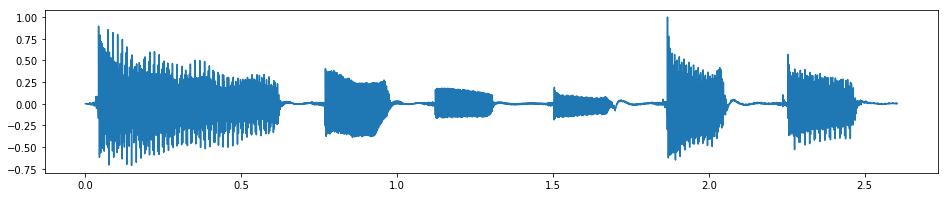

In [13]:
testfile = '../../../../../datasets/fender/test/test_data.wav'
ytest, fs = soundfile.read(testfile, start=0, frames=None)
ytest = ytest.reshape(-1,1)
ytest /= np.max(np.abs(ytest))
Ntest = ytest.size
xtest = np.linspace(0, (Ntest-1.)/fs, Ntest).reshape(-1, 1)

plt.figure()
plt.plot(xtest, ytest)
print Ntest

In [14]:
kern_loo = kern_com_60 + kern_com_64
kf = [kern_com_67, kern_loo]
kg = [kern_act_67, kern_act_60]
dec = 160
maxiter = 4000
minibatch_size = 417
learning_rate = 0.01
ztest = xtest[::dec].copy()

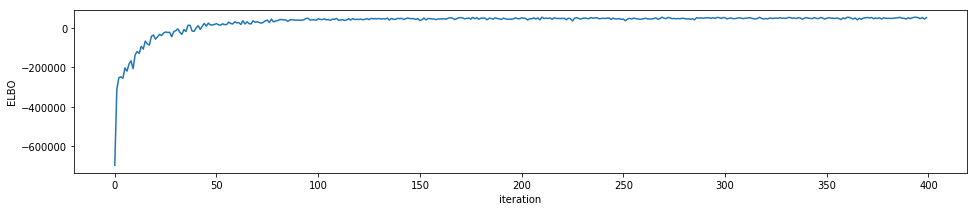

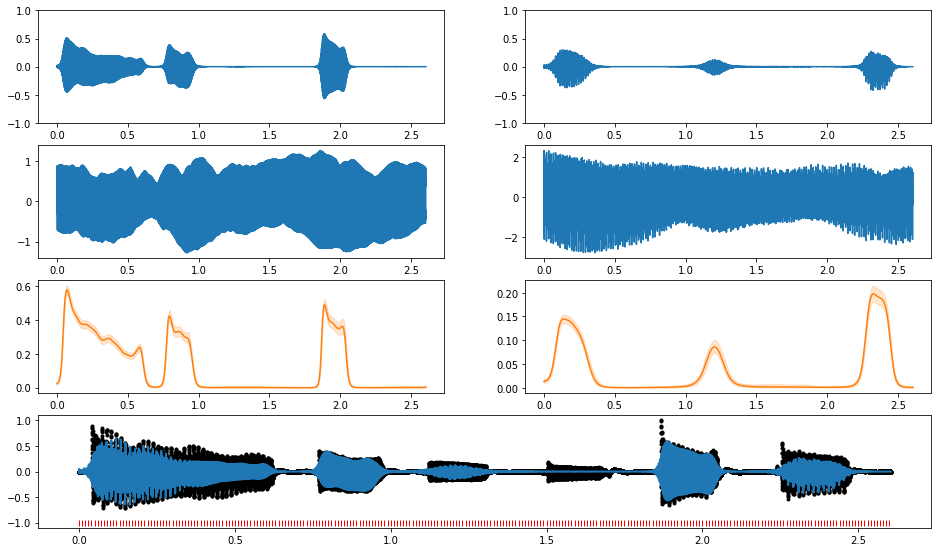

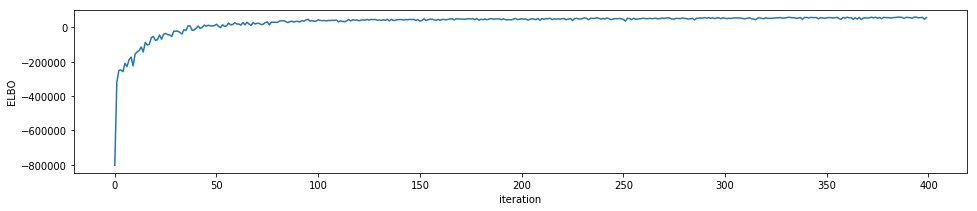

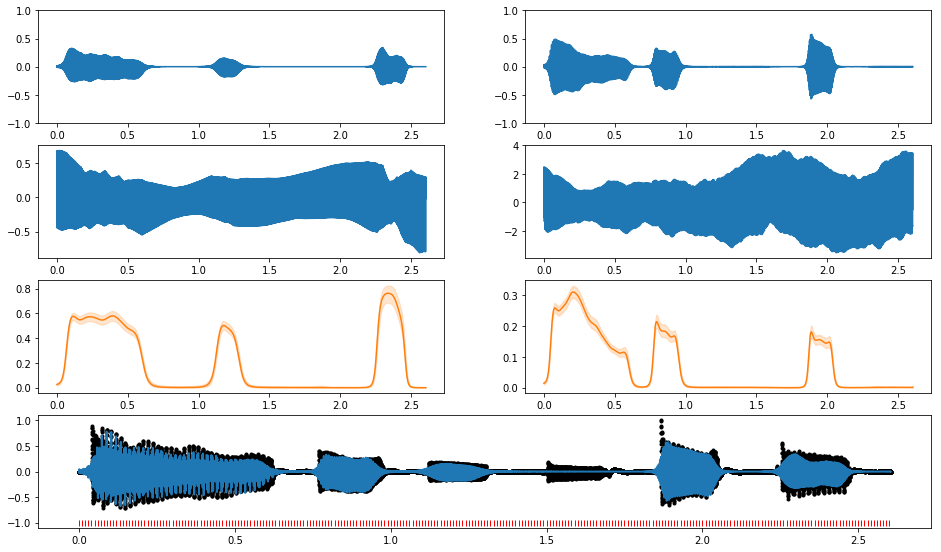

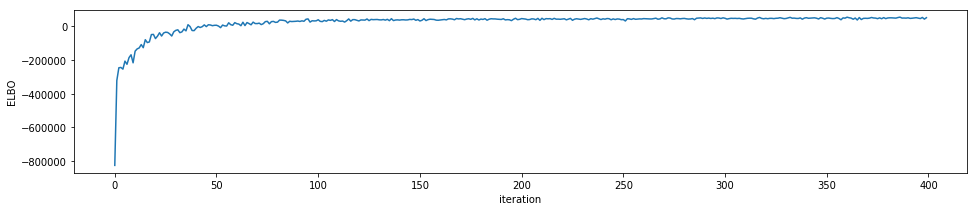

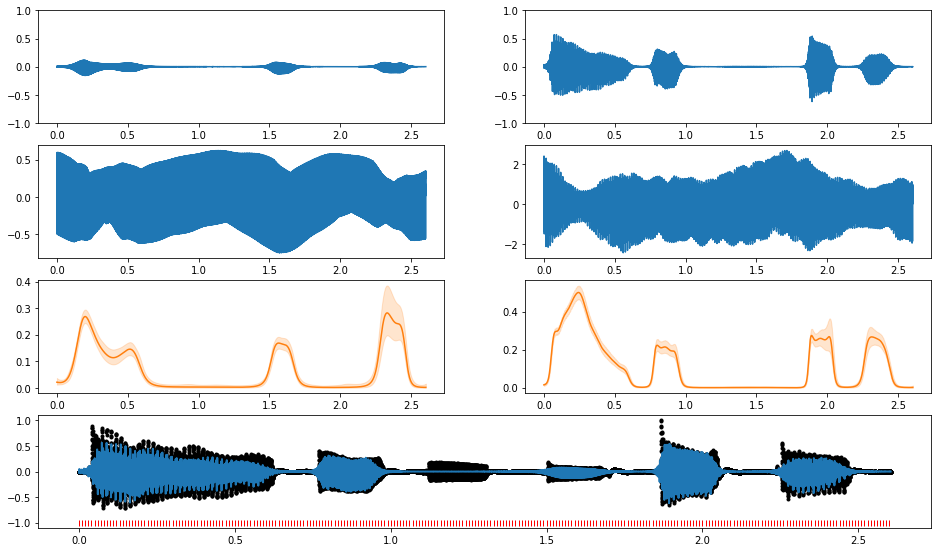

In [15]:
 for i in range(3):
    if i == 0:
        kern_loo = kern_com_64 + kern_com_67
        kf = [kern_com_60, kern_loo]
        kg = [kern_act_60, kern_act_64]
        
    if i == 1:
        kern_loo = kern_com_60 + kern_com_67
        kf = [kern_com_64, kern_loo]
        kg = [kern_act_64, kern_act_60]
        
    if i == 2:
        kern_loo = kern_com_60 + kern_com_64
        kf = [kern_com_67, kern_loo]
        kg = [kern_act_67, kern_act_60]
    
    m = gpitch.loogp.LooGP(X=xtest, Y=ytest, kf=kf, kg=kg, Z=ztest, minibatch_size=minibatch_size)
    m.optimize_svi(maxiter=maxiter, learning_rate=learning_rate)
    mean_f, var_f, mean_g, var_g = m.predict_all(xtest)

    plt.figure()
    plt.plot(-np.array(m.logf))
    plt.xlabel('iteration')
    plt.ylabel('ELBO')

    gpitch.myplots.plot_loo(mean_f=mean_f, var_f=var_f, mean_g=mean_g, var_g=var_g, x_plot=xtest, 
                            y=ytest, z=m.Z.value, xlim=None)

    tf.reset_default_graph()